# How many notebooks do I need for one goddamn POC?

## Part one - MTCNN

I have found a lot ready-to-use facial landmark solutions but many of them were aimed for a CLI-style usage where you specify path to a file or pass a PIL Image to a class method. This is not differentiable, I don't need that. From the doom and gloom of my late afternoon hours spent on looking at the artificial light of old laptop screen a hope has arisen. I've encountered my long forgotten friend - [facenet-pytorch](https://github.com/timesler/facenet-pytorch) implementation, that not only can use images as an input, but serve as a PyTorch model itself. Moreover, if configured directly it can provide landmarks. I shall give this a try 

### Story one - does it detect faces?

Can it detect faces? I have no idea. Let's give it a try!

#### "Real" examples

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt


from lightweight_gan import LightweightGAN
import torch
import numpy as np

from PIL import Image
from torchvision.transforms import v2


from facenet_pytorch import MTCNN

MODEL_PATH = Path("model/model_mercury_5_param_9000.pt")
LATENT_DIM = 256
IMG_SIZE = 256

torch.manual_seed(42)


/home/pawel/Documents/studia/magisterka/CKTinderator/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow((im_arr*255).astype(np.uint8))


def import_generator(model_filepath: Path) -> torch.nn.Module:
    model = torch.load(model_filepath)
    
    gan = LightweightGAN(latent_dim=LATENT_DIM,
                         image_size=IMG_SIZE, 
                         attn_res_layers=[32],
                         freq_chan_attn=False)
    gan.load_state_dict(model["GAN"], strict=False)
    gan.eval()

    return gan.G

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).cuda(0)


def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow((255*images[i]).reshape(images[idx].shape[0], images[idx].shape[1]).astype(np.uint8))
        else:
            ax.imshow((255*images[idx]).astype(np.uint8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_loss(losses, iterations, title=""):
    plt.plot(iterations, losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.ylim(bottom=0, top=1.1*max(losses))
    plt.show()
    
    
def present_results(z, checkpoints, losses, original_image):
    generator = import_generator(MODEL_PATH)
    plot_images([checkpoint for _, checkpoint in checkpoints],
            [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints],
            nrows=len(checkpoints)//4, ncols=4,
            title="Generated images for parameters with value 128", figsize=[8, 6])
    
    original_image
    original_middle_image = prep_tensor_to_show(original_image)
    inffered_middle_image = prep_tensor_to_show(generator(z)[0])
    plot_images([original_middle_image, inffered_middle_image],
            ["original", "inferred"], 
            nrows=1, ncols=2,
            title="Original and inferred image",
            figsize=[8, 4])
    
    plot_loss(losses, checkpoints, title="Losses")

In [3]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 

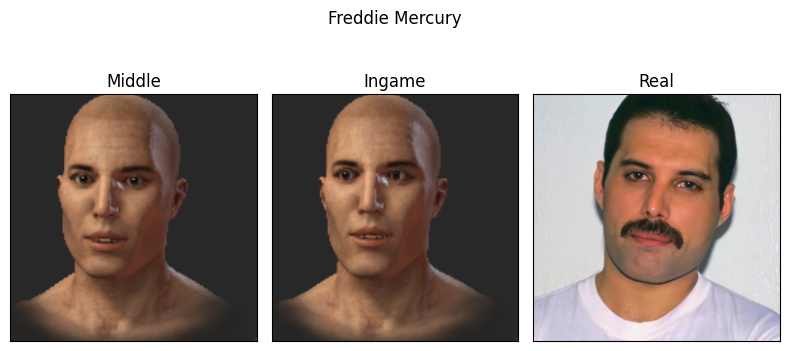

In [3]:
MIDDLE_IMAGE_PATH = "img/from_dataset/middle_mercury.png"
FREDDIE_INGAME_PATH = "img/from_dataset/perfect_mercury.png"
FREDDIE_REAL_PATH = "img/real-freddies/1.jpg"

middle_image = prep_image(MIDDLE_IMAGE_PATH)
freddie_ingame = prep_image(FREDDIE_INGAME_PATH)
freddie_real = prep_image(FREDDIE_REAL_PATH)

plot_images([prep_tensor_to_show(img) for img in (middle_image, freddie_ingame, freddie_real)],
            ["Middle", "Ingame", "Real"],
            1, 3, title="Freddie Mercury")

In [5]:
mtcnn = MTCNN(image_size=IMG_SIZE, device="cuda:0")
# prepared_image = (255 * freddie_real.permute((1,2,0))).to(torch.int64)
# print(prepared_image)
mtcnn.detect(Image.open(MIDDLE_IMAGE_PATH), landmarks=True)

torch.float32


(array([[30.725900650024414, 23.273630142211914, 105.12242889404297,
         128.79115295410156]], dtype=object),
 array([0.999332845211029], dtype=object),
 array([[[49.369606018066406, 65.9628677368164],
         [82.0940933227539, 68.36476135253906],
         [60.5847282409668, 88.7621078491211],
         [49.26322555541992, 106.72156524658203],
         [76.42453002929688, 108.96076202392578]]], dtype=object))

In [8]:
mtcnn.detect(middle_image.permute(()), landmarks=True)

torch.float32


(None, array([None], dtype=object), None)

### Story two - does it detect generated landmarks?

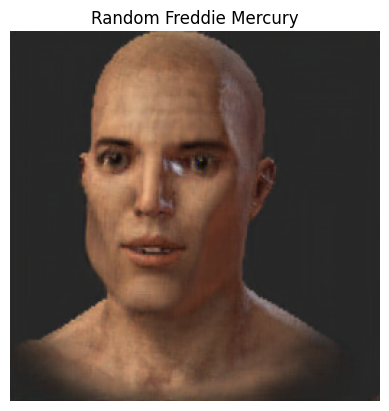

In [4]:
generator = import_generator(MODEL_PATH)

random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
generated_images = generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random Freddie Mercury")

OK, fail. Now something completely different.

## [Face alignment library](https://github.com/1adrianb/face-alignment)

I will do some strange things here:



In [5]:
import os
import sys
import errno

from urllib.parse import urlparse
from torch.hub import download_url_to_file, HASH_REGEX
try:
    from torch.hub import get_dir
except BaseException:
    from torch.hub import _get_torch_home as get_dir

two_d_model_url = "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip"
three_d_model_url = "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip"
depth_url = "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip"



def load_file_from_url(url, model_dir=None, progress=True, check_hash=False, file_name=None):
    if model_dir is None:
        hub_dir = get_dir()
        model_dir = os.path.join(hub_dir, 'checkpoints')

    try:
        os.makedirs(model_dir)
    except OSError as e:
        if e.errno == errno.EEXIST:
            # Directory already exists, ignore.
            pass
        else:
            # Unexpected OSError, re-raise.
            raise

    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if file_name is not None:
        filename = file_name
    cached_file = os.path.join(model_dir, filename)
    if not os.path.exists(cached_file):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
        hash_prefix = None
        if check_hash:
            r = HASH_REGEX.search(filename)  # r is Optional[Match[str]]
            hash_prefix = r.group(1) if r else None
        download_url_to_file(url, cached_file, hash_prefix, progress=progress)

    return cached_file


two_d_model = torch.jit.load(load_file_from_url(two_d_model_url)).to("cuda:0").eval()
# three_d_model = torch.jit.load(load_file_from_url(three_d_model_url))
# depth_precision = torch.jit.load(load_file_from_url(depth_url))

In [6]:
def softargmax2d(input, beta=100):
    *_, w, h = input.shape

    input = input.reshape(*_, w * h)
    input = torch.nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w))).to("cuda:0")
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w))).to("cuda:0")

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_c, result_r], dim=-1)

    return result


def differentiable_landmarks(image):
    return softargmax2d(two_d_model(image.unsqueeze(0)))

In [6]:
inp = middle_image.unsqueeze(0)
out = two_d_model(inp)

In [7]:
out.shape

torch.Size([1, 68, 64, 64])

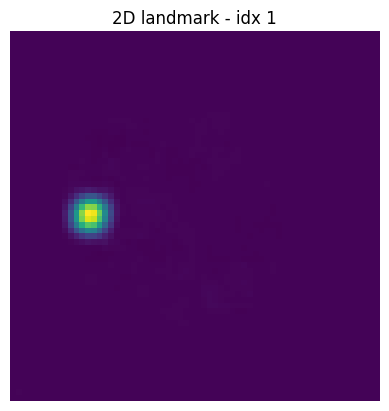

In [46]:
def show_heatmap(heatmap, title=""):
    plt.imshow(heatmap[2].detach().to("cpu").numpy(), cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.show()
    
show_heatmap(out[0], title="2D landmark - idx 1")

In [7]:
def softargmax2d(input, beta=100):
    *_, w, h = input.shape

    input = input.reshape(*_, w * h)
    input = torch.nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w))).to("cuda:0")
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w))).to("cuda:0")

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_c, result_r], dim=-1)

    return result

softargmax2d(out)

NameError: name 'out' is not defined

In [9]:
inp = freddie_real.unsqueeze(0)
heatmap = two_d_model(inp)
landmarks = softargmax2d(heatmap)

/tmp/ipykernel_11103/2405133924.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(landmarks[0, :, 0], landmarks[0, :, 1], cmap="viridis")


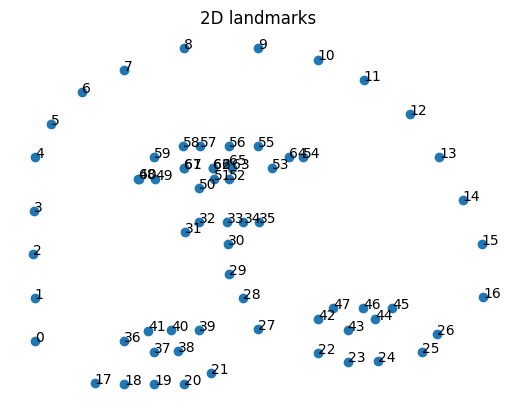

In [10]:
def show_landmarks_numbered(landmarks, title=""):
    plt.scatter(landmarks[0, :, 0], landmarks[0, :, 1], cmap="viridis")
    for i, (x, y) in enumerate(landmarks[0]):
        plt.text(x, y, str(i))
    plt.title(title)
    plt.axis("off")
    plt.show()
    
show_landmarks_numbered(landmarks.detach().cpu(), title="2D landmarks")

/tmp/ipykernel_11103/2302170483.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(4*landmarks[0, :, 0], 4*landmarks[0, :, 1], cmap="viridis")


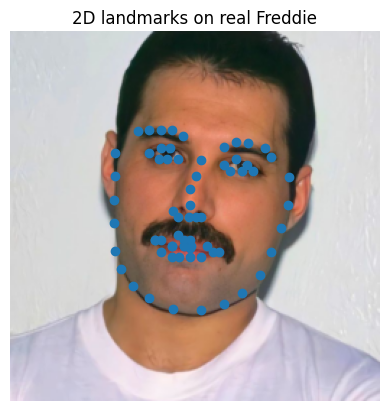

In [11]:
def show_landmarks_on_face(landmarks, image, title=""):
    plt.imshow(prep_tensor_to_show(image))
    plt.scatter(4*landmarks[0, :, 0], 4*landmarks[0, :, 1], cmap="viridis")
    plt.title(title)
    plt.axis("off")
    plt.show()
    
show_landmarks_on_face(landmarks.detach().cpu(), freddie_real, title="2D landmarks on real Freddie")

In [19]:
def differentiable_landmarks(image_tensor):
    inp = image_tensor.unsqueeze(0)
    heatmap = two_d_model(inp)
    return softargmax2d(heatmap)



for i in range(10):
    random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
    generated_images = generator(random_latent_vectors)
    landmarks = differentiable_landmarks(generated_images[0])
    show_landmarks_on_face(landmarks.detach().cpu(), generated_images[0], title="2D landmarks on generated Freddie")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


/tmp/ipykernel_127612/2302170483.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(4*landmarks[0, :, 0], 4*landmarks[0, :, 1], cmap="viridis")


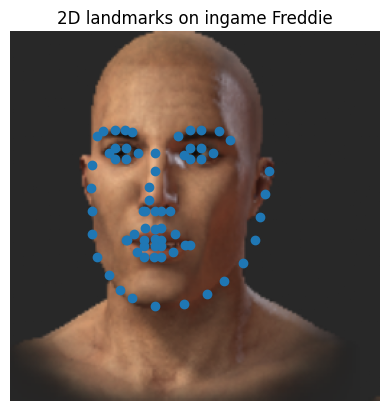

In [64]:
freddie_ingame_landmarks = differentiable_landmarks(freddie_ingame)

show_landmarks_on_face(freddie_ingame_landmarks.detach().cpu(), freddie_ingame, title="2D landmarks on ingame Freddie")

/tmp/ipykernel_11103/2302170483.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(4*landmarks[0, :, 0], 4*landmarks[0, :, 1], cmap="viridis")


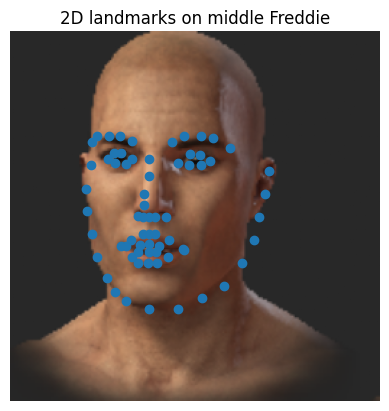

In [16]:
middle_image_landmarks = differentiable_landmarks(middle_image)
show_landmarks_on_face(middle_image_landmarks.detach().cpu(), middle_image, title="2D landmarks on middle Freddie")

In [17]:
def find_z_landmarks(exemplary_photo, iterations=100, lr=5, checkpoint_step=10, z_init=None):
    z = torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda") \
        if z_init is None else z_init

    y_target = differentiable_landmarks(exemplary_photo).detach()

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam([z], lr=lr)

    checkpoints = []
    losses = []
    for i in range(iterations):
        generated_image = generator(z)[0]
        y_pred = differentiable_landmarks(generated_image)
        print(y_pred)
        loss = criterion(y_target, y_pred)

        if i % checkpoint_step == 0:
            checkpoints.append((i, generated_image.detach().permute((1,2,0)).cpu().numpy()))
            losses.append(loss.item())
            print(f"Iteration: {i}, loss: {loss.item():.2E}")
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return z, checkpoints, losses

In [19]:
z, checkpoints, losses = find_z_landmarks(middle_image, iterations=100, lr=5, checkpoint_step=10)

Iteration: 0, loss: 8.70E-01


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [8]:
class DifferentiableLandmarks(torch.nn.Module):
    def __init__(self, generator, landmarks_model):
        super().__init__()
        self.z = torch.nn.Parameter(torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda"))
        
        self.model = landmarks_model
        self.generator = generator
        self.generator.eval()
        self.model.eval()
        
    def forward(self):
        return self.model(self.generator(self.z))
    
    
generator = import_generator(MODEL_PATH).to("cuda:0")
landmarks_model = torch.jit.load(load_file_from_url(two_d_model_url)).to("cuda:0").eval()

model = DifferentiableLandmarks(generator, landmarks_model)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
y_target = landmarks_model(middle_image.unsqueeze(0)).detach()

checkpoints = []
landmark_checkpoints = []
for i in range(100):
    y_pred = model()
    loss = criterion(y_target, y_pred)
    if i % 10 == 0:
        checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
        landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Iteration: {i}, loss: {loss.item():.2E}")
    

Iteration: 0, loss: 1.81E-04
Iteration: 1, loss: 1.24E-04
Iteration: 2, loss: 1.07E-04
Iteration: 3, loss: 5.94E-05
Iteration: 4, loss: 3.12E-05
Iteration: 5, loss: 2.85E-05
Iteration: 6, loss: 1.98E-05
Iteration: 7, loss: 1.57E-05
Iteration: 8, loss: 1.53E-05
Iteration: 9, loss: 1.22E-05
Iteration: 10, loss: 1.01E-05
Iteration: 11, loss: 1.05E-05
Iteration: 12, loss: 9.65E-06
Iteration: 13, loss: 7.07E-06
Iteration: 14, loss: 5.93E-06
Iteration: 15, loss: 5.65E-06
Iteration: 16, loss: 4.88E-06
Iteration: 17, loss: 4.20E-06
Iteration: 18, loss: 4.16E-06
Iteration: 19, loss: 4.11E-06
Iteration: 20, loss: 3.73E-06
Iteration: 21, loss: 3.15E-06
Iteration: 22, loss: 2.91E-06
Iteration: 23, loss: 2.84E-06
Iteration: 24, loss: 2.56E-06
Iteration: 25, loss: 2.22E-06
Iteration: 26, loss: 2.04E-06
Iteration: 27, loss: 1.89E-06
Iteration: 28, loss: 1.76E-06
Iteration: 29, loss: 1.63E-06
Iteration: 30, loss: 1.50E-06
Iteration: 31, loss: 1.47E-06
Iteration: 32, loss: 1.36E-06
Iteration: 33, loss:

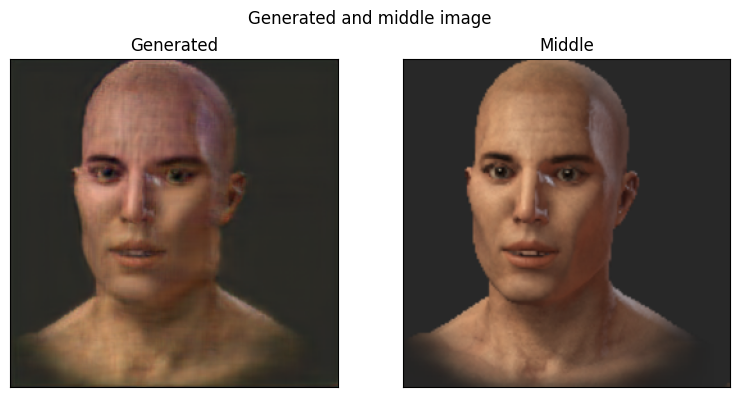

In [9]:
plot_images([prep_tensor_to_show(model.generator(model.z)[0]), prep_tensor_to_show(middle_image)], ["Generated", "Middle"], 1, 2, title="Generated and middle image")

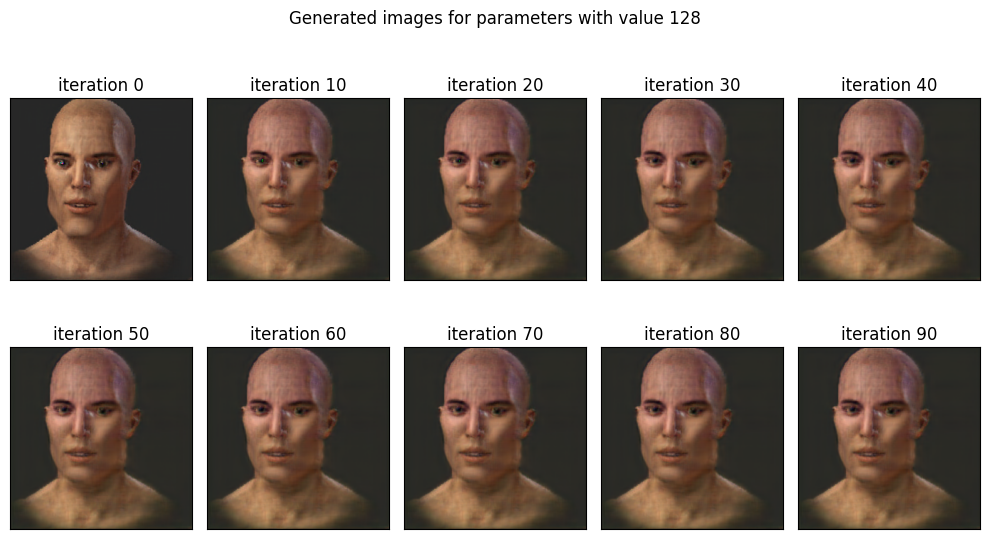

In [10]:
plot_images([checkpoint for _, checkpoint in checkpoints], [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints], nrows=len(checkpoints)//5, ncols=5, title="Generated images for parameters with value 128", figsize=[10, 6])

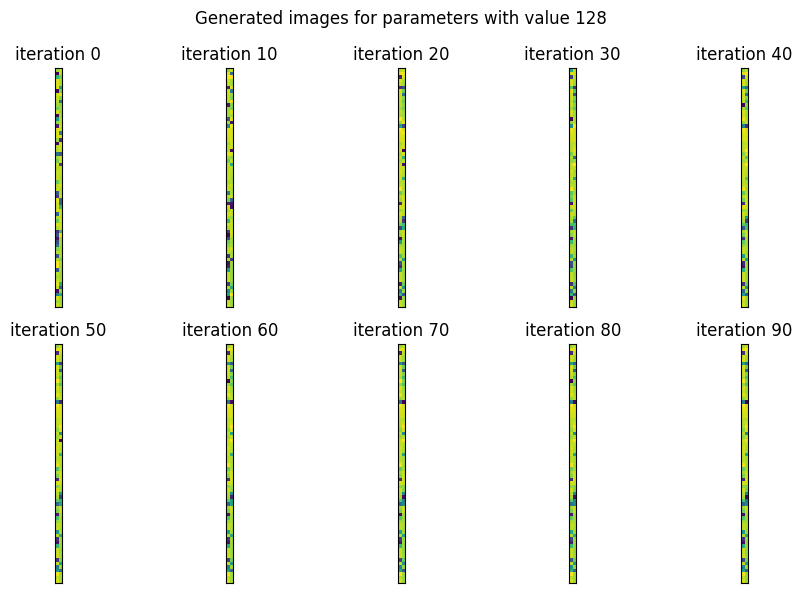

In [60]:
plot_images([checkpoint for _, checkpoint in landmark_checkpoints], [f"iteration {checkpoint_n}" for checkpoint_n, _ in landmark_checkpoints], nrows=len(landmark_checkpoints)//5, ncols=5, title="Generated images for parameters with value 128", figsize=[10, 6])

In [11]:
model = DifferentiableLandmarks(generator, landmarks_model)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
y_target = landmarks_model(freddie_ingame.unsqueeze(0)).detach()

checkpoints = []
landmark_checkpoints = []
for i in range(100):
    y_pred = model()
    loss = criterion(y_target, y_pred)
    if i % 10 == 0:
        checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
        landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Iteration: {i}, loss: {loss.item():.2E}")
    


Iteration: 0, loss: 7.89E-04
Iteration: 1, loss: 3.99E-04
Iteration: 2, loss: 1.93E-04
Iteration: 3, loss: 7.37E-05
Iteration: 4, loss: 2.74E-05
Iteration: 5, loss: 3.50E-05
Iteration: 6, loss: 6.72E-05
Iteration: 7, loss: 5.81E-05
Iteration: 8, loss: 4.11E-05
Iteration: 9, loss: 2.91E-05
Iteration: 10, loss: 2.18E-05
Iteration: 11, loss: 1.74E-05
Iteration: 12, loss: 1.49E-05
Iteration: 13, loss: 1.34E-05
Iteration: 14, loss: 1.14E-05
Iteration: 15, loss: 9.85E-06
Iteration: 16, loss: 8.38E-06
Iteration: 17, loss: 7.65E-06
Iteration: 18, loss: 7.01E-06
Iteration: 19, loss: 6.42E-06
Iteration: 20, loss: 6.12E-06
Iteration: 21, loss: 5.65E-06
Iteration: 22, loss: 5.20E-06
Iteration: 23, loss: 4.77E-06
Iteration: 24, loss: 4.43E-06
Iteration: 25, loss: 4.18E-06
Iteration: 26, loss: 3.82E-06
Iteration: 27, loss: 3.55E-06
Iteration: 28, loss: 3.30E-06
Iteration: 29, loss: 2.99E-06
Iteration: 30, loss: 2.76E-06
Iteration: 31, loss: 2.66E-06
Iteration: 32, loss: 2.60E-06
Iteration: 33, loss:

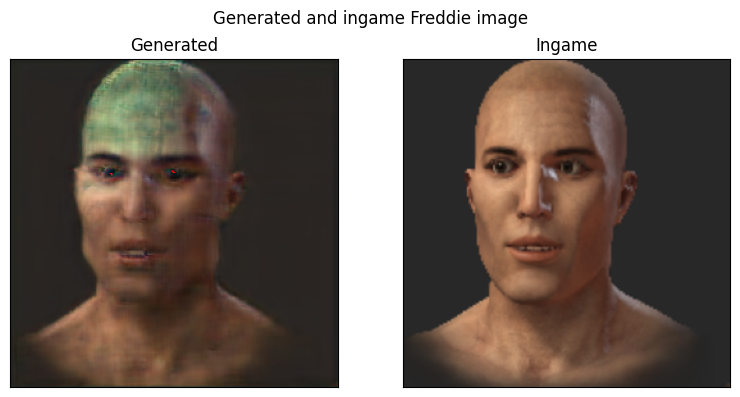

In [13]:
plot_images([prep_tensor_to_show(model.generator(model.z)[0]), prep_tensor_to_show(freddie_ingame)], ["Generated", "Ingame"], 1, 2, title="Generated and ingame Freddie image")

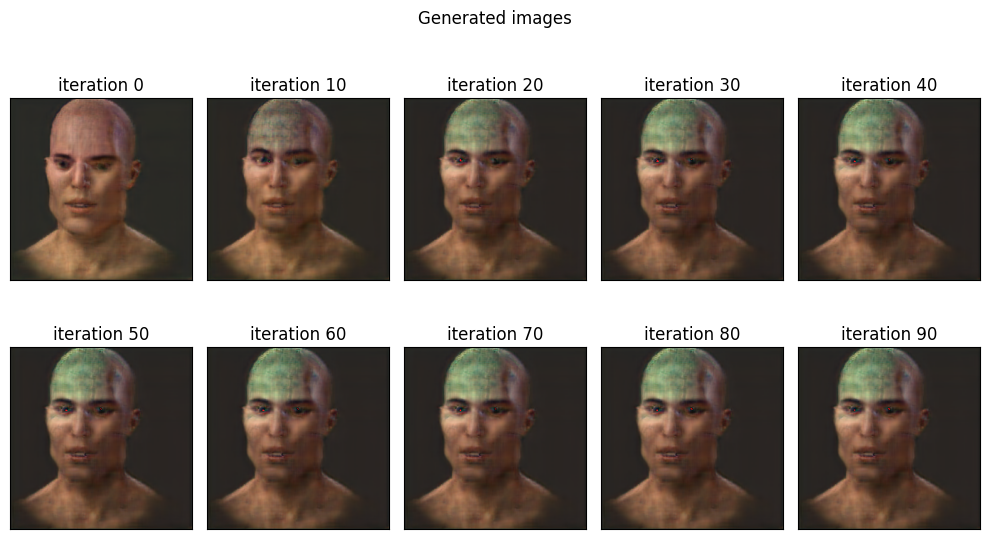

In [14]:
plot_images([checkpoint for _, checkpoint in checkpoints], [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints], nrows=len(checkpoints)//5, ncols=5, title="Generated images", figsize=[10, 6])

In [15]:
model = DifferentiableLandmarks(generator, landmarks_model)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
y_target = landmarks_model(freddie_real.unsqueeze(0)).detach()

checkpoints = []
landmark_checkpoints = []
for i in range(100):
    y_pred = model()
    loss = criterion(y_target, y_pred)
    if i % 10 == 0:
        checkpoints.append((i, model.generator(model.z)[0].detach().permute((1,2,0)).cpu().numpy()))
        landmark_checkpoints.append((i, softargmax2d(y_pred[0]).detach().cpu().numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Iteration: {i}, loss: {loss.item():.2E}")
    


Iteration: 0, loss: 4.10E-03
Iteration: 1, loss: 3.42E-03
Iteration: 2, loss: 2.78E-03
Iteration: 3, loss: 2.18E-03
Iteration: 4, loss: 1.74E-03
Iteration: 5, loss: 1.49E-03
Iteration: 6, loss: 1.37E-03
Iteration: 7, loss: 1.23E-03
Iteration: 8, loss: 1.11E-03
Iteration: 9, loss: 9.53E-04
Iteration: 10, loss: 7.78E-04
Iteration: 11, loss: 6.12E-04
Iteration: 12, loss: 4.94E-04
Iteration: 13, loss: 3.99E-04
Iteration: 14, loss: 3.15E-04
Iteration: 15, loss: 2.60E-04
Iteration: 16, loss: 2.17E-04
Iteration: 17, loss: 1.85E-04
Iteration: 18, loss: 1.61E-04
Iteration: 19, loss: 1.40E-04
Iteration: 20, loss: 1.22E-04
Iteration: 21, loss: 1.04E-04
Iteration: 22, loss: 9.03E-05
Iteration: 23, loss: 7.62E-05
Iteration: 24, loss: 6.39E-05
Iteration: 25, loss: 5.30E-05
Iteration: 26, loss: 4.71E-05
Iteration: 27, loss: 3.96E-05
Iteration: 28, loss: 3.44E-05
Iteration: 29, loss: 2.91E-05
Iteration: 30, loss: 2.60E-05
Iteration: 31, loss: 2.32E-05
Iteration: 32, loss: 2.07E-05
Iteration: 33, loss:

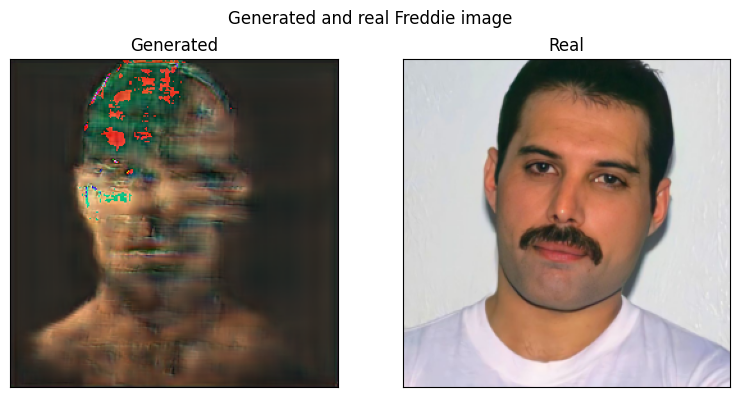

In [17]:
plot_images([prep_tensor_to_show(model.generator(model.z)[0]), prep_tensor_to_show(freddie_real)], ["Generated", "Real"], 1, 2, title="Generated and real Freddie image")

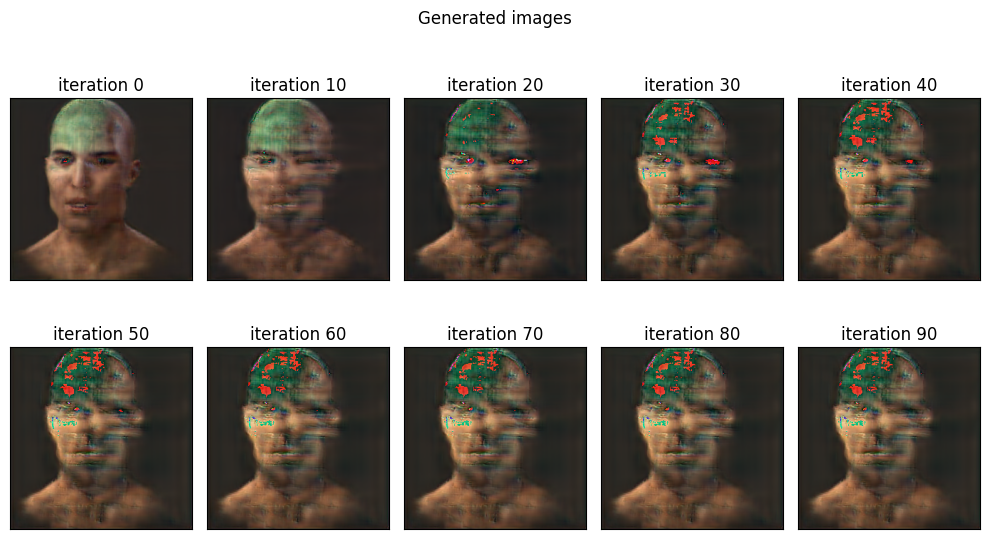

In [18]:
plot_images([checkpoint for _, checkpoint in checkpoints], [f"iteration {checkpoint_n}" for checkpoint_n, _ in checkpoints], nrows=len(checkpoints)//5, ncols=5, title="Generated images", figsize=[10, 6])